In [1]:
### from __future__ import division, absolute_import

import os
import sys
import random

import numpy as np

#root
absPath = '/home/angela/padding_EBI/'
sys.path.insert(0, absPath)

#from src.Target import Target

np.random.seed(8)
random.seed(8)

from src.preprocessing import *
from src.model_architecture import *
from src.training_model import *
from src.postprocessing import *
from src.comparing_results import *
#from src.callbacks import *
%matplotlib inline

Using TensorFlow backend.


### Defining parameters

In [2]:
list_paddings = ['post_padding', 
                 'pre_padding', 
    'mid_padding', 'strf_padding', 'ext_padding', 
                 'rnd_padding', 
                 #'aug_padding'
                ]
#list_paddings = ['aug_padding']
#list_padding_short = ['post_padding', 'pre_padding', 'mid_padding', 'stretch_padding', 'ext_padding', 
#                 'rdm_padding']
#hierarchy of folders: annotation/dataset/architecture/n_neurs/task/padding
folder = 'EC_number/archaea/3denses/bio_neurons/'
task = "task1/"
column = "EC number"
task_string = "Task 1"

n_folds = 10

#dicti = creating_dict()

#max_lenn = 1000

### Loading stuff

In [ ]:
file_idcs_aug = os.path.join(absPath, 'data/', folder, 'idcs_aug_split.pickle')

with open(file_idcs_aug, "rb") as input_file:
    k_aug_indices = pickle.load(input_file)
    
file_idcs = os.path.join(absPath, 'data/', folder, 'idcs_split.pickle')

with open(file_idcs, "rb") as input_file:
    splitting_sets = pickle.load(input_file)

## Processing results

In [ ]:
for model_type in list_paddings:
    if model_type == "aug_padding":
        indices = k_aug_indices
    else:
        indices = splitting_sets
    for idx,i in enumerate(indices):
        print('Fold: ', idx)
        i_train, i_val, i_test = i
        #loading best model
        processing_results(folder, task, model_type, idx, i_test, "labels_task1")

# Plotting

### History

In [ ]:
#hay que modificar esta funcion para q acerque task
df_his,k = collecting_metrics_folds("history", list_paddings, folder, task, n_folds)
plotting_history(df_his, task_string, folder, task, k)

### Accuracy

In [ ]:
scores_final, accu = processing_metrics_results(list_paddings, folder, task, n_folds)

In [ ]:
plotting_auc_acc_boxplots(accu, folder, "accuracy", n_folds, task_string, task)

### Scores

In [ ]:
plotting_scores_boxplots(scores_final, folder, n_folds, task_string, task)

### AUC

In [ ]:
df_auc,k = collecting_metrics_folds("auc", list_paddings, folder, n_folds)
df_auc2 = processing_roc_auc(df_auc, "auc", list_paddings)

plotting_auc_acc_boxplots(accu, folder, "auc", n_folds, task_string, task)

### ROC curves 

In [ ]:
df_roc,k = collecting_metrics_folds("roc", list_paddings, folder, n_folds)
df_roco = processing_roc_auc(df_roc, "roc", list_paddings)

plotting_ROC_curves(df_roco, folder, n_folds, task_string, list_paddings, task)

In [ ]:
# BORRAR CUANDO FUNCIONE

for model_type in list_paddings:
    if model_type == "aug_padding":
        indices = k_aug_indices
    else:
        indices = splitting_sets
    for idx,i in enumerate(indices):
        print('Fold: ', idx)
        i_train, i_val, i_test = i
        print(i_test)
        #loading best model
        his_folder = ''.join(string for string in [absPath, 'data/results/', folder, task, model_type, 
                                                   '/', str(idx)])
        history = plot_history(his_folder)
        path_to_cp = ''.join(string for string in [absPath, 'data/checkpoint/', folder, task, model_type, 
                                            '/', str(idx)])
        model, best_path = load_best_model(history, path_to_cp)
        cps_loc = ''.join(string for string in [absPath, 'data/checkpoint/', folder, task, model_type, 
                                            '/', str(idx), '/*.hdf5'])
        #removing the rest of weights
        fileList = glob.glob(cps_loc, recursive=True)
        fileList.remove(best_path)
        if len(fileList) >1:
            for filePath in fileList:
                try:
                    os.remove(filePath)
                except OSError:
                    print("Error while deleting file")
        #loading test data        
        if model_type == "aug_padding":
            file_data = os.path.join(absPath, 'data/', folder, 'aug_data.h5')
        else:
            file_data = os.path.join(absPath, 'data/', folder, 'data.h5')
        h5f = h5py.File(file_data, 'r')
    
        instarget = Target('AAAAAA')
        x_test = h5f[model_type][sorted(i_test)]
        x_test = instarget.int_to_onehot(list(x_test), len(dicti))
        y_test = h5f["labels_task1"][sorted(i_test)]
    
        #predicting 
        y_predprob = model.predict(x_test)
        y_pred = y_predprob.argmax(axis=-1)
        y_test_scalar = y_test.argmax(axis=-1)
        y_prob = y_predprob[:,1]
    
        print(Counter(y_pred))
    
        #confusion matrix
        #file_conf = ''.join(string for string in [his_folder, '/resulting_metrics.pickle'])    
        confusion_matrix(y_test_scalar, y_pred, his_folder)
    
        #AUC
        file_auc = ''.join(string for string in [his_folder, '/AUC.pickle'])
        compute_roc(y_test_scalar, y_prob, his_folder )
    
        computing_partial_auc(y_test_scalar, y_prob, his_folder)

In [3]:
folder = folder+task

In [4]:
folder

'EC_number/archaea/3denses/bio_neurons/task1/'

In [5]:
df_auc,k = collecting_metrics_folds("auc", list_paddings, folder, n_folds)
df_auc.columns = ['post_padding', 'pre_padding', 'mid_padding', 'strf_padding',
       'ext_padding', 'rnd_padding']
df_auc= df_auc.reset_index(0)
df_auc = df_auc.melt(id_vars='index')
#

In [6]:
df_auc.head()

,index,variable,value
0,0,post_padding,0.874609
1,1,post_padding,0.907310
2,2,post_padding,0.906274
3,3,post_padding,0.959577
4,4,post_padding,0.950664


In [7]:
p = (ggplot(df_auc, aes(x="variable", y="value", fill="variable"))
    +geom_boxplot()
    + scale_fill_brewer(palette="Set3", type='qual')
    +theme_bw()
    +theme(aspect_ratio=1, legend_title=element_blank(), axis_text_y =element_text(size=10),
                legend_text=element_text(size=14), strip_text_x = element_text(size=10), axis_text_x = element_blank(),
          legend_key_size = 14, axis_title_y=element_blank(), axis_title_x=element_blank(), 
           #legend_position="bottom", legend_box="horizontal", 
           plot_title = element_text(size=20))
    + ggtitle("Task 1 - AUC (%i holdouts)" %n_folds)
     #+ guides(fill=guide_legend(nrow=1))
)

p

file_auc = ''.join(string for string in [absPath,'data/results/', folder])
p.save(path = file_auc, format = 'pdf', dpi=300, filename="aucs_comparison.pdf")

/home/angela/.local/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/angela/.local/lib/python3.6/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units))
/home/angela/.local/lib/python3.6/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: /home/angela/padding_EBI/data/results/EC_number/archaea/3denses/bio_neurons/task1/aucs_comparison.pdf
  warn('Filename: {}'.format(filename))
/home/angela/.local/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/angela/.local/lib/python3.6/site-packages/p

In [8]:
df_his,k = collecting_metrics_folds("history", list_paddings, folder, n_folds)

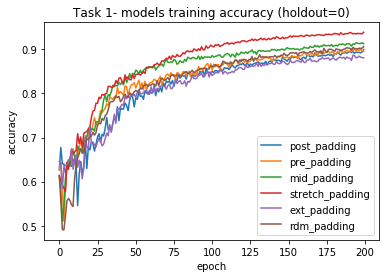

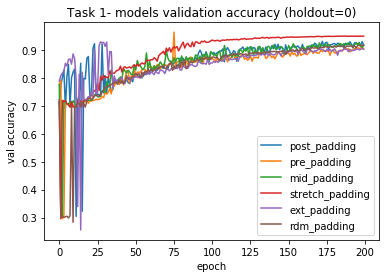

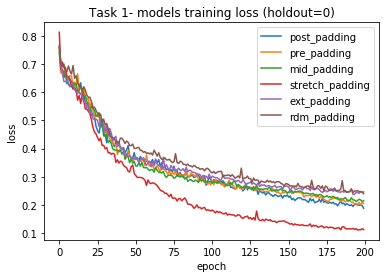

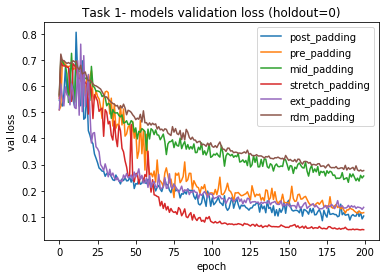

In [9]:
plotting_history(df_his, "Task 1", folder, k)

In [10]:
scores_final, accu = processing_metrics_results(list_paddings, folder, n_folds)

In [11]:
accu.loc[accu.variable == "stretch_padding", "variable"] = "strf_padding"
accu.loc[accu.variable == "rdm_padding", "variable"] = "rnd_padding"

In [26]:
p = (ggplot(accu, aes(x="variable", y="value", fill="variable"))
        +geom_boxplot()
        + scale_fill_brewer(palette="Set3", type='qual')
        +theme_bw()
        +theme(aspect_ratio=1, axis_text_y =element_text(size=12),
             strip_text_x = element_text(size=10), axis_text_x = element_blank(),
              legend_position=None, axis_title_y=element_blank(), axis_title_x=element_blank(), 
           #legend_position="bottom", legend_box="horizontal", 
           plot_title = element_text(size=20))
        + ggtitle("Task 1 - Accuracy on test (10 holdouts)")
    )

file_auc = ''.join(string for string in [absPath,'data/results/', folder])
p.save(path = file_auc, format = 'pdf', dpi=300, filename="test_accuracy_comparison.pdf")

/home/angela/.local/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/angela/.local/lib/python3.6/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units))
/home/angela/.local/lib/python3.6/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: /home/angela/padding_EBI/data/results/EC_number/archaea/3denses/bio_neurons/task1/test_accuracy_comparison.pdf
  warn('Filename: {}'.format(filename))
/home/angela/.local/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/angela/.local/lib/python3.6/site-p

/home/angela/.local/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)
/home/angela/.local/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)
/home/angela/.local/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)
/home/angela/.local/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  re

In [ ]:
plotting_auc_acc_boxplots(accu, folder, "accuracy", n_folds, "Task 1")


In [ ]:
scores_final.loc[scores_final.type_padding == "stretch_padding", "type_padding"] = "strf_padding"
scores_final.loc[scores_final.type_padding == "rdm_padding", "type_padding"] = "rnd_padding"



In [ ]:
dicti_enz = {"0":"1", "1":"2", "2":"3", "3":"4", "4":"5", "5":"6", "6":"7", "macro avg": "macro avg", 
             "micro avg": "micro avg", "weighted avg": "weighted avg"}

In [ ]:
scores_final["enz_type_2"] = scores_final["enz_type"].apply(lambda x: dicti_enz[x])
scores_final.head()

In [ ]:
plotting_scores_boxplots(scores_final, folder, n_folds, "Task 1")

In [ ]:
def plotting_scores_boxplots(df, folder, nfolds, task):
    """Plotting F1-score/precision/recall on test values in boxplots"""
    p = (ggplot(df, aes(x='type_padding', y="value", fill='type_padding'))
         +geom_boxplot(outlier_size=1)
         + scale_fill_brewer(palette="Set3", type='qual')
         +theme_bw()
         +theme(figure_size=(24,16), aspect_ratio=1, legend_title=element_blank(), axis_text_y =element_text(size=9),
                legend_text=element_text(size=12), strip_text_x = element_text(size=9), axis_text_x = element_blank(),
               strip_text_y = element_text(size=9), plot_title = element_text(size=15), axis_title_y = element_blank(),
               axis_title_x = element_text(size = 9), legend_key_size = 12, legend_position="bottom", 
                legend_box="horizontal")
         + facet_grid("variable~enz_type_2")
         + ggtitle("%s - performance metrics (%i holdouts)" %(task, nfolds))
         + guides(fill=guide_legend(nrow=1))
    )
    file_met = ''.join(string for string in [absPath,'data/results/', folder])
    p.save(path = file_met, format = 'pdf', dpi=300, filename="scores.pdf")
    return p

In [ ]:
plotting_scores_boxplots(scores_final, folder, n_folds, "Task 1")

In [13]:
df_roc,k = collecting_metrics_folds("roc", list_paddings, folder, n_folds)
df_roc.columns = ['post_padding', 'pre_padding', 'mid_padding', 'strf_padding',
       'ext_padding', 'rnd_padding']
df_roco= processing_roc_auc(df_roc, "roc")
df_roco

,index,variable,fpr,tpr,_
0,0,post_padding,"[0.0, 0.00229182582124, 0.00305576776165, 0.00...","[0.0, 0.108192620388, 0.116948092558, 0.120700...","[2.0, 1.0, 1.0, 1.0, 1.0, 0.999999, 0.999999, ..."
1,1,post_padding,"[0.0, 0.00152788388083, 0.00152788388083, 0.00...","[0.0, 0.0969355847405, 0.103189493433, 0.10506...","[2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.999999, 0.999..."
2,2,post_padding,"[0.0, 0.000763941940413, 0.000763941940413, 0....","[0.0, 0.0775484677924, 0.0838023764853, 0.0888...","[2.0, 1.0, 1.0, 1.0, 1.0, 0.999999, 0.999999, ..."
3,3,post_padding,"[0.0, 0.00305576776165, 0.00305576776165, 0.00...","[0.0, 0.109443402126, 0.12382739212, 0.1332082...","[2.0, 1.0, 1.0, 1.0, 1.0, 0.999999, 0.999999, ..."
4,4,post_padding,"[0.0, 0.00229182582124, 0.00229182582124, 0.00...","[0.0, 0.0881801125704, 0.0969355847405, 0.1025...","[2.0, 1.0, 1.0, 1.0, 1.0, 0.999999, 0.999999, ..."
5,5,post_padding,"[0.0, 0.00305576776165, 0.00305576776165, 0.00...","[0.0, 0.173858661664, 0.188242651657, 0.194496...","[2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.999999, 0.999..."
6,6,post_padding,"[0.0, 0.000763941940413, 0.000763941940413, 0....","[0.0, 0.0819262038774, 0.0925578486554, 0.0975...","[2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.999999, 0.999..."
7,7,post_padding,"[0.0, 0.00152788388083, 0.00152788388083, 0.00...","[0.0, 0.131957473421, 0.147592245153, 0.152595...","[2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.999999, 0.999..."
8,8,post_padding,"[0.0, 0.0, 0.0, 0.000763941940413, 0.000763941...","[0.0, 0.00250156347717, 0.0168855534709, 0.016...","[2.0, 1.0, 0.999458, 0.999167, 0.998023, 0.996..."
9,9,post_padding,"[0.0, 0.00152788388083, 0.00152788388083, 0.00...","[0.0, 0.108818011257, 0.117573483427, 0.121325...","[2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.999999, 0.999..."


In [24]:
def plotting_ROC_curves(df, folder, nfolds, task, list_paddings):
    """Plotting ROC curves"""
    k = random.randint(0, nfolds-1)
    df = df.loc[df["index"] == k]
    fig = plt.figure(figsize=(12,9))
    lw = 3
    for i in list_paddings:
        plt.plot(df.loc[df.variable==i, "fpr"].values[0], df.loc[df.variable==i, "tpr"].values[0], label=i, lw=3)
    #plt.plot(fpr, tpr, lw=lw)
    plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
    plt.axis('scaled')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate', fontsize = 20)
    plt.ylabel('True Positive Rate', fontsize = 20)
    plt.legend(prop={'size': 18})
    #plt.title("%s - ROC curves (holdout=%i)" %(task,k), size=24)
    plt.title("Task 1 - ROC curves", size=24)
    file_fig = ''.join(string for string in [absPath,'data/results/', folder, 'ROC_curves.pdf'])
    plt.savefig(file_fig)
    plt.show()

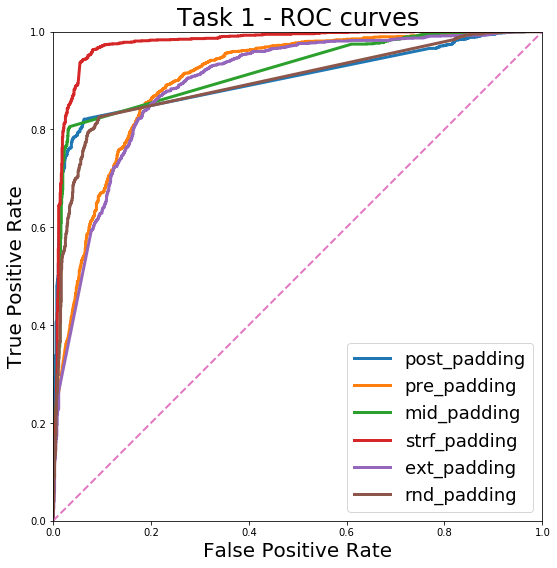

In [25]:
task
plotting_ROC_curves(df_roco, folder, n_folds, "Task 1", ['post_padding', 'pre_padding', 'mid_padding', 'strf_padding',
       'ext_padding', 'rnd_padding'])

In [ ]:
k = random.randint(0, n_folds-1)
df = df_roco.loc[df_roco["index"] == k]
df